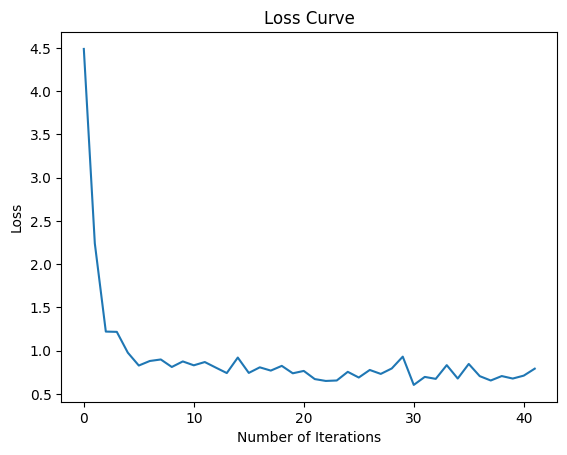

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Baca file test sama train
train_data = pd.read_csv('csv/train.csv')
test_data = pd.read_csv('csv/test.csv')

# -- Variabel umum, dimodifikasi untuk kasus khusus, Tentukan kolom yang ingin di drop dan kolom yang menjadi target
dropped_columns = ['PassengerId', 'HomePlanet', 'Destination', 'Age', 'VIP', 'Name', 'CryoSleep']
target_column = 'Transported'

# Ini untuk memilah fitur agar data mudah diolah kedepannya, fitur yang bersifat kategorikal dan fitur yang bersifat numerikal
categorical_features = train_data.drop(columns=dropped_columns + [target_column]).select_dtypes(include=['object']).columns.tolist()
numerical_features = train_data.drop(columns=dropped_columns + [target_column]).select_dtypes(exclude=['object']).columns.tolist()

# Ini adalah fungsi transformasi yang digunakan untuk fitur kategorikal non ordinal
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),                           # Mengisi null value dengan data modus (yang sering muncul)
    # Jika kode diatas tidak dipakai, berarti menggunakan unknown sebagai fitur
    ('onehot', OneHotEncoder(sparse_output=False).set_output(transform='pandas'))   # Setelah diisi datanya
])                                                                                  # OneHotEncoder mengubah kategorikal menjadi biner (numerikal)

# Ini adalah fungsi transformasi yang digunakan untuk fitur numerikal non ordinal
numerical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))               # Mengisi null value dengan data median
])

# Untuk menggabungkan kedua transformasi pada 1 step
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_imputer, numerical_features)
    ])

# Agar proses lebih sinkron dan mengurangi kemungkinan terjadinya kesalahan pada sinkronisasi data
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fungsi buat ngambil huruf S sama P di Side
def extract_last_cabin_part(s):
    if isinstance(s, str):
        parts = s.split('/')
        return parts[-1]
    else:
        return s

# Membersihkan data buat di training

# Drop kolom yang tidak relevan menurut persepsi kelompok terhadap soal (train.csv)
x_train = train_data.drop(columns=dropped_columns + [target_column])
y_train = train_data[target_column]

# -- Fungsi khusus lakukan pembersihan data lanjutan sesuai logika yang dianggap benar (train.csv)
x_train['Cabin'] = x_train['Cabin'].apply(extract_last_cabin_part)

# Mengubah dari data mentah ke data yang akan dilatih (train.csv)
transformed_X_train = pipeline.fit_transform(x_train)

# Drop kolom yang tidak relevan menurut persepsi kelompok terhadap soal (test.csv)
x_test = test_data.drop(columns=dropped_columns)

# -- Fungsi khusus lakukan pembersihan data lanjutan sesuai logika yang dianggap benar (test.csv)
x_test['Cabin'] = x_test['Cabin'].apply(extract_last_cabin_part)

# Mengubah dari data mentah ke data yang akan di uji coba (test.csv)
transformed_X_test = pipeline.transform(x_test)

model = MLPClassifier(max_iter=1000)
model.fit(transformed_X_train, y_train)

loss_values = model.loss_curve_
plt.plot(loss_values)
plt.title('Loss Curve')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.show()

predictions = model.predict(transformed_X_test)

passenger_ids = test_data['PassengerId']
output_df = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': predictions})
output_df.to_csv('predictions_NN.csv', index=False)